In [44]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [45]:
# with open("./output_files/couples_new.json") as json_file:
#     couples = json.load(json_file)

# with open("./output_files/compare/Melan.A/che_phy.json") as json_file:
#     couples_by_che = json.load(json_file)

# with open("./output_files/compare/Melan.A/leve.json") as json_file:
#     couples_by_lev = json.load(json_file)

with open("./output_files/tests/cdr3_amino_acid/test.json") as json_file:
    couples = json.load(json_file)

# couples = couples_by_che

In [46]:
max_neig = 2
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    count = 0
    for neighbor, weight in neighbors:
        if count < max_neig:
            G.add_edge(node, neighbor, weight=weight)
            count += 1

In [47]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

In [ ]:
edge_colors = get_edges_colors(G)



plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=8)

# # Draw edge labels with three numbers after the decimal point
# edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True)}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

plt.title('Amino Acid Sequence Graph')
plt.axis('off')  # Turn off axis
plt.savefig('lev_Melan.A_whole.png')
plt.show()

### Highest degree node

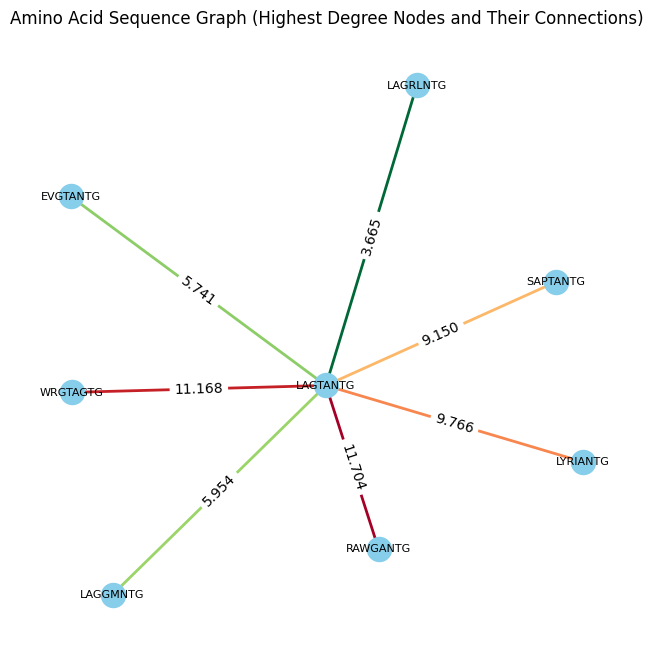

In [48]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)

# Draw edge labels with three numbers after the decimal point
edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in H.edges(data=True)}
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='black')

plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('degree.png')
plt.show()


### Longest path

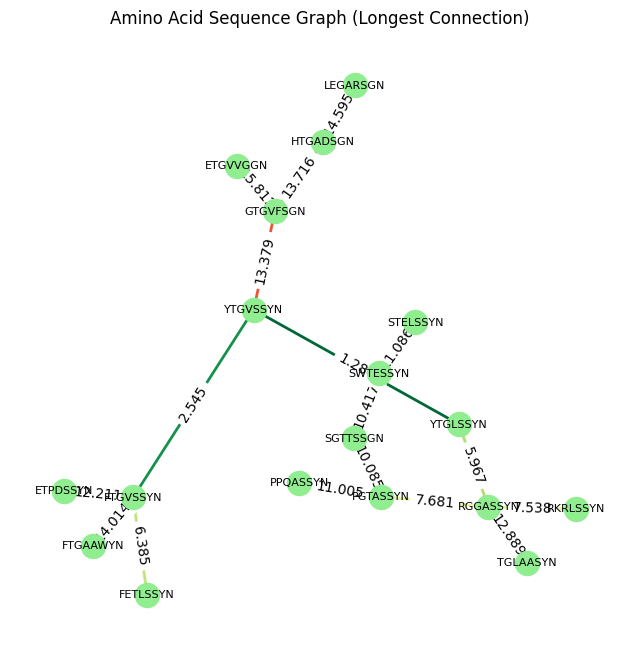

In [49]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)

# Draw edge labels with three numbers after the decimal point
edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in H.edges(data=True)}
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='black')


plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('longest_path.png')
plt.show()

In [50]:
# Find the minimum spanning tree
mst = nx.minimum_spanning_tree(G)

# Sort the edges by weight
sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]['weight'])

# Get the 5 strongest connections (lowest weights)
strongest_connections = sorted_edges[:30]

# Print the 5 strongest connections
for edge in strongest_connections:
    print(edge)


('RVAGGLTD', 'RLAGGLTD', {'weight': 1.284128108873877})
('YTGVSSYN', 'YTGLSSYN', {'weight': 1.284128108873877})
('PLAGGSTG', 'PLAGGDTG', {'weight': 2.296208831966291})
('YTGVSSYN', 'FTGVSSYN', {'weight': 2.545205885581754})
('VGGGYSTD', 'LGGTYSTD', {'weight': 3.0854162590597376})
('LGPSGGQE', 'QGPSGGQE', {'weight': 3.274172567229773})
('SPGGSNTG', 'SSGGSNTG', {'weight': 3.476415251376049})
('LAGTANTG', 'LAGRLNTG', {'weight': 3.665391188034781})
('STTGYGQE', 'STTGTGDE', {'weight': 3.6819415177889354})
('QDRTGGNQ', 'QDRAGGNQ', {'weight': 3.769443725538293})
('LDGTGYYN', 'LDGGGTYN', {'weight': 3.852837077216362})
('LGLAGGLY', 'LGLAGGLE', {'weight': 3.932187686263208})
('LGQGLTNE', 'LRQGATNE', {'weight': 4.0224488836806165})
('PTASGGAE', 'PRASGGVE', {'weight': 4.147050535301211})
('LALAGGTD', 'LGLAGGTD', {'weight': 4.264347429560588})
('LGPSAGQE', 'LGPSGGQE', {'weight': 4.264347429560588})
('DSGGAGAN', 'LSGGAGAN', {'weight': 4.280608367977617})
('DSGQGRTY', 'QSRQGRTY', {'weight': 4.4048170